# Compact Convolutional Transformer for MI-EEG Classification

In [1]:
from model.cct import CCT
from torchinfo import summary

import warnings
warnings.filterwarnings("ignore")

/home/islab-shi/anaconda3/envs/eegcct/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pickle 
import torch 
import time
import numpy as np
import pandas as pd 
import random
import mne
import sys
import matplotlib.pyplot as plt

import torch.nn as nn
from torch import Tensor
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

In [3]:
model = CCT(kernel_sizes=[(22, 1), (1, 24)], stride=(1, 1), padding=(0, 0),
            pooling_kernel_size=(3, 3), pooling_stride=(1, 1), pooling_padding=(0, 0),
            n_conv_layers=2, n_input_channels=1,
            in_planes=64, activation=None, # ReLU
            max_pool=False, conv_bias=False,
            dim=64, num_layers=3,
            num_heads=4, num_classes=2, 
            attn_dropout=0.1, dropout=0.1, 
            mlp_size=64, positional_emb="learnable")

In [4]:
summary(model=model,
        input_size=(64, 1, 22, 1000),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
CCT (CCT)                                          [64, 1, 22, 1000]    [64, 2]              --                   True
├─Tokenizer (tokenizer)                            [64, 1, 22, 1000]    [64, 977, 64]        --                   True
│    └─Sequential (conv_layers)                    [64, 1, 22, 1000]    [64, 64, 1, 977]     --                   True
│    │    └─Sequential (0)                         [64, 1, 22, 1000]    [64, 64, 1, 1000]    1,408                True
│    │    └─Sequential (1)                         [64, 64, 1, 1000]    [64, 64, 1, 977]     98,304               True
│    └─Flatten (flattener)                         [64, 64, 1, 977]     [64, 64, 977]        --                   --
├─Transformer (transformer)                        [64, 977, 64]        [64, 2]              62,528               True
│    └─Dropout (dropout)                     

## Data Loading

In [5]:
datasets = [
    '/workspace-cloud/seiya.narukawa/EEGCCT/pickles/A01.pkl',
    '/workspace-cloud/seiya.narukawa/EEGCCT/pickles/A02.pkl',
    '/workspace-cloud/seiya.narukawa/EEGCCT/pickles/A03.pkl',
    '/workspace-cloud/seiya.narukawa/EEGCCT/pickles/A04.pkl',
    '/workspace-cloud/seiya.narukawa/EEGCCT/pickles/A05.pkl',
    '/workspace-cloud/seiya.narukawa/EEGCCT/pickles/A06.pkl',
    '/workspace-cloud/seiya.narukawa/EEGCCT/pickles/A07.pkl',
    '/workspace-cloud/seiya.narukawa/EEGCCT/pickles/A08.pkl',
    '/workspace-cloud/seiya.narukawa/EEGCCT/pickles/A09.pkl',
]

In [6]:
def load_data(filename):
    """
    Load data from a file.
    :param filename: Path to the data file.
    :return: Loaded data.
    """
    with open(filename, 'rb') as handle:
        data = pickle.load(handle)
    return data

In [7]:
import glob
# ① ファイルパスリストから被験者ごとの dict をまとめて読み込む
datasets = sorted(glob.glob("pickles/A*.pkl"))
all_subjects = [load_data(fn) for fn in datasets]

# ② subject=0 の辞書を取ってくる
subj0 = all_subjects[0]

# ③ train セッションのデータ
train = subj0["train"]
X_train = train["X"]          # shape=(288,22,1000)
y_train = train["y"]          # label array (0 or 1、artifactマスク等でフィルタ)

# ④ eval セッションのデータ
eval_ = subj0["eval"]
X_eval = eval_["X"]
y_eval = eval_["y"]           # None のはず

# ⑤ メタ情報
meta = subj0["meta"]
print(meta)

{'subject': 'A01', 'sfreq': 250.0, 'ch_names': ['EEG-Fz', 'EEG-0', 'EEG-1', 'EEG-2', 'EEG-3', 'EEG-4', 'EEG-5', 'EEG-C3', 'EEG-6', 'EEG-Cz', 'EEG-7', 'EEG-C4', 'EEG-8', 'EEG-9', 'EEG-10', 'EEG-11', 'EEG-12', 'EEG-13', 'EEG-14', 'EEG-Pz', 'EEG-15', 'EEG-16'], 'label_map': {'left': 0, 'right': 1, 'feet': 2, 'tongue': 3}, 'window': '0.0–4.0 s (cue-locked)'}


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == 'cuda':
    print('Your GPU device name :', torch.cuda.get_device_name()) 

Your GPU device name : NVIDIA GeForce RTX 2080 Ti


## Initialization of Parameters and Model

In [10]:
def initialize_model(test_sub, val_sub, n_subj=9):
    """
    Initialize parameters, model, and loss functions.
    :param test_sub: Index of the test subject.
    :param val_sub: Index of the validation subject.
    :param n_subj: Total number of subjects.
    :return: Initialized model and parameters.
    """
    parameters = {
        'batch_size': 32,
        'n_epochs': 100,
        'lr': 3e-5,
        'b1': 0.9,
        'b2': 0.999,
        'test_Sub': test_sub,
        'val_Sub': val_sub,
        'n_subjects': n_subj
    }

    model = CCT(kernel_sizes=[(22, 1), (1, 24)], stride=(1, 1), padding=(0, 0),
                pooling_kernel_size=(3, 3), pooling_stride=(1, 1), pooling_padding=(0, 0),
                n_conv_layers=2, n_input_channels=1, in_planes=64, activation=None,  # ReLU
                max_pool=False, conv_bias=False, dim=64, num_layers=3, num_heads=4, num_classes=2,
                attn_dropout=0.1, dropout=0.1, mlp_size=64, positional_emb="learnable")

    if torch.cuda.is_available():
        model = model.cuda()

    loss_functions = {
        'criterion_l1': nn.L1Loss().cuda(),
        'criterion_l2': nn.MSELoss().cuda(),
        'criterion_cls': nn.CrossEntropyLoss().cuda()
    }

    return model, parameters, loss_functions

## Data Loading and Preprocessing

In [12]:
def get_source_data(test_sub, val_sub, n_subj=9):
    # １）全被験者ロード
    all_data = [load_data(fn) for fn in datasets]
    
    # ２）テスト／バリデーション辞書
    test_d = all_data[test_sub]['train']
    val_d  = all_data[val_sub] ['train']
    
    # ３）残りでトレイン
    train_idxs = [i for i in range(n_subj) if i not in (test_sub,val_sub)]
    train_ds   = [all_data[i]['train'] for i in train_idxs]
    
    # ４）X,y をそれぞれ取り出して連結
    X_train = np.concatenate([d['X'] for d in train_ds], axis=0)
    y_train = np.concatenate([d['y'] for d in train_ds], axis=0)
    X_val   = val_d ['X']
    y_val   = val_d ['y']
    X_test  = test_d['X']
    y_test  = test_d['y']
    
    # ５）２クラスフィルタリング：left(0), right(1) のみ残す
    mask_tr = np.isin(y_train, [0,1])
    X_train, y_train = X_train[mask_tr], y_train[mask_tr]
    mask_val = np.isin(y_val, [0,1])
    X_val,   y_val   = X_val[mask_val],   y_val[mask_val]
    mask_te  = np.isin(y_test, [0,1])
    X_test,  y_test  = X_test[mask_te],  y_test[mask_te]

    # ６）あとは既存の次元展開／シャッフル／標準化…
    X_train = np.expand_dims(X_train,1)
    X_val   = np.expand_dims(X_val,  1)
    X_test  = np.expand_dims(X_test, 1)

    # shuffle train
    idx = np.random.permutation(len(X_train))
    X_train, y_train = X_train[idx], y_train[idx]

    # standardize based on train set
    μ, σ = X_train.mean(), X_train.std()
    X_train = (X_train - μ) / σ
    X_val   = (X_val   - μ) / σ
    X_test  = (X_test  - μ) / σ

    return X_train, y_train, X_val, y_val, X_test, y_test


In [14]:
def prepare_dataloaders(X_train, y_train, X_val, y_val, batch_size):
    """
    Convert numpy arrays to PyTorch tensors and prepare DataLoaders for training and validation.
    :param X_train: Training data (numpy array).
    :param y_train: Training labels (numpy array).
    :param X_val: Validation data (numpy array).
    :param y_val: Validation labels (numpy array).
    :param batch_size: Batch size for the DataLoader.
    :return: DataLoaders for training and validation.
    """
    # Convert numpy arrays to Tensors
    train_data = torch.from_numpy(X_train).type(torch.cuda.FloatTensor)
    train_labels = torch.from_numpy(y_train).type(torch.cuda.LongTensor)
    val_data = torch.from_numpy(X_val).type(torch.cuda.FloatTensor)
    val_labels = torch.from_numpy(y_val).type(torch.cuda.LongTensor)

    # Prepare DataLoader for training data
    train_dataset = TensorDataset(train_data, train_labels)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

    # Prepare DataLoader for validation data
    val_dataset = TensorDataset(val_data, val_labels)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [15]:
def augment_data(X, y, batch_size, n_segments=3):
    # X: (n_trials,1,22,1000)
    n_trials,_,n_ch,n_t = X.shape
    half = batch_size // 2

    # 1000 samples を n_segments 等分する境界を計算
    bounds = [ int(round(i * n_t / n_segments)) for i in range(n_segments+1) ]
    # e.g. bounds = [0, 333, 667, 1000]

    aug_data  = np.zeros((half,1,n_ch,n_t), dtype=X.dtype)
    aug_label = np.zeros(half,      dtype=y.dtype)

    classes = [0,1]  # 左手/右手 のラベル

    for i in range(half):
        lbl = np.random.choice(classes)
        aug_label[i] = lbl

        # 各セグメントごとに同クラスからランダムに試行を選ぶ
        idxs = np.where(y == lbl)[0]
        picks = np.random.choice(idxs, size=n_segments, replace=True)

        segments = []
        for s in range(n_segments):
            st, ed = bounds[s], bounds[s+1]
            segments.append(X[picks[s], 0, :, st:ed])

        # 再度連結して長さ 1000 に戻す
        new_trial = np.concatenate(segments, axis=-1)  # (22,1000)
        aug_data[i,0] = new_trial

    # Tensor 化して GPU へ
    tdata   = torch.from_numpy(aug_data).float().cuda()
    tlabels = torch.from_numpy(aug_label).long().cuda()
    return tdata, tlabels

## Model Training

In [16]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        """
        Initialize the EarlyStopping object.
        :param patience: Number of epochs to wait after min has been hit. After this number, training stops.
        :param min_delta: Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            #print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [17]:
def train_model(model, optimizer, loss_functions, train_loader, val_loader, parameters, X_train, y_train, early_stopping):
    """
    Train the model.
    :param model: The neural network model to train.
    :param optimizer: Optimizer for the model.
    :param criterion_cls: Loss function for classification.
    :param train_loader: DataLoader for training data.
    :param val_loader: DataLoader for validation data.
    :param n_epochs: Number of epochs to train the model.
    :return: Trained model.
    """
    # Lists to keep track of metrics
    train_losses, val_losses, val_accuracies = [], [], []
    
    # Training loop
    for epoch in range(parameters['n_epochs']):
        model.train()
        train_loss = 0.0
        
        for i, (images, labels) in enumerate(train_loader):
            images = images.cuda()
            labels = labels.cuda()
            
            # Data augmentation
            aug_images, aug_labels = augment_data(X_train, y_train, parameters['batch_size'])
            images = torch.cat((images, aug_images))
            labels = torch.cat((labels, aug_labels))

            # Forward pass
            outputs = model(images)
            loss = loss_functions['criterion_cls'](outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

        # Validation accuracy
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in val_loader:
                images = images.cuda()
                labels = labels.cuda()
                outputs = model(images)
                loss = loss_functions['criterion_cls'](outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
            # Calculate average losses and accuracy
            train_loss = train_loss / len(train_loader)
            val_loss = val_loss / len(val_loader)
            val_accuracy = 100 * correct / total
            print(f'Epoch [{epoch+1}/{parameters["n_epochs"]}], Train Loss: {loss.item():.4f}, Val Acc: {val_accuracy:.2f}%')
            
        # Append metrics to lists
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        # Check early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    return model, train_losses, val_losses, val_accuracies

## Model Evaluation

In [18]:
def test_model(model, loss_functions, test_loader):
    """
    Test the model using the test dataset.
    :param model: The trained neural network model.
    :param criterion_cls: Loss function for classification.
    :param test_loader: DataLoader for test data.
    :return: Test accuracy and test loss.
    """
    # Evaluate the model
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.cuda()
            labels = labels.cuda()

            outputs = model(images)
            loss = loss_functions['criterion_cls'](outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
    
    return test_accuracy, test_loss

seed is 362
Val Subject 2:
Epoch [1/100], Train Loss: 0.6921, Val Acc: 50.00%
Epoch [2/100], Train Loss: 0.6988, Val Acc: 50.00%
Epoch [3/100], Train Loss: 0.6892, Val Acc: 50.69%
Epoch [4/100], Train Loss: 0.6909, Val Acc: 50.69%
Epoch [5/100], Train Loss: 0.6997, Val Acc: 50.69%
Epoch [6/100], Train Loss: 0.6823, Val Acc: 52.08%
Epoch [7/100], Train Loss: 0.6732, Val Acc: 57.64%
Epoch [8/100], Train Loss: 0.6690, Val Acc: 56.25%
Epoch [9/100], Train Loss: 0.6795, Val Acc: 53.47%
Epoch [10/100], Train Loss: 0.6576, Val Acc: 51.39%
Epoch [11/100], Train Loss: 0.6597, Val Acc: 59.72%
Epoch [12/100], Train Loss: 0.6856, Val Acc: 61.11%
Epoch [13/100], Train Loss: 0.6842, Val Acc: 58.33%
Epoch [14/100], Train Loss: 0.6838, Val Acc: 58.33%
Epoch [15/100], Train Loss: 0.7254, Val Acc: 59.03%
Epoch [16/100], Train Loss: 0.7219, Val Acc: 59.03%
Epoch [17/100], Train Loss: 0.7982, Val Acc: 58.33%
Early stopping


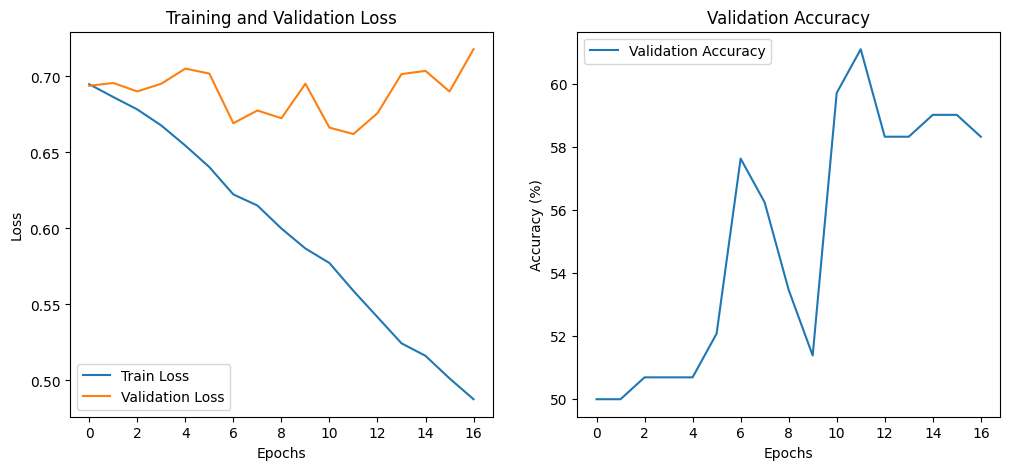

Test Loss: 0.7624, Test Accuracy: 56.94%
Test Subject 1: Test Acc = 56.94%, Test Loss = 0.7624
Training complete in 1m 16s

seed is 1585
Val Subject 3:
Epoch [1/100], Train Loss: 0.6988, Val Acc: 43.75%
Epoch [2/100], Train Loss: 0.7005, Val Acc: 44.44%
Epoch [3/100], Train Loss: 0.6983, Val Acc: 47.22%
Epoch [4/100], Train Loss: 0.7011, Val Acc: 48.61%
Epoch [5/100], Train Loss: 0.7077, Val Acc: 45.14%
Epoch [6/100], Train Loss: 0.7090, Val Acc: 44.44%
Epoch [7/100], Train Loss: 0.7106, Val Acc: 47.22%
Epoch [8/100], Train Loss: 0.7159, Val Acc: 52.78%
Epoch [9/100], Train Loss: 0.7106, Val Acc: 48.61%
Epoch [10/100], Train Loss: 0.7062, Val Acc: 59.03%
Epoch [11/100], Train Loss: 0.7021, Val Acc: 62.50%
Epoch [12/100], Train Loss: 0.6810, Val Acc: 70.83%
Epoch [13/100], Train Loss: 0.7011, Val Acc: 68.06%
Epoch [14/100], Train Loss: 0.6539, Val Acc: 75.69%
Epoch [15/100], Train Loss: 0.6268, Val Acc: 77.08%
Epoch [16/100], Train Loss: 0.6008, Val Acc: 81.25%
Epoch [17/100], Train Los

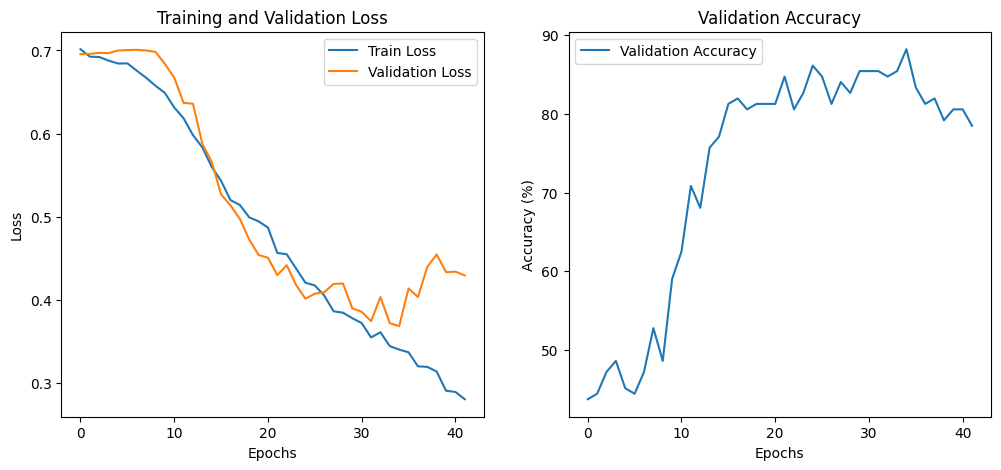

Test Loss: 1.1948, Test Accuracy: 50.69%
Test Subject 2: Test Acc = 50.69%, Test Loss = 1.1948
Training complete in 3m 8s

seed is 52
Val Subject 4:
Epoch [1/100], Train Loss: 0.7044, Val Acc: 50.00%
Epoch [2/100], Train Loss: 0.7057, Val Acc: 49.31%
Epoch [3/100], Train Loss: 0.7049, Val Acc: 48.61%
Epoch [4/100], Train Loss: 0.7026, Val Acc: 54.17%
Epoch [5/100], Train Loss: 0.7045, Val Acc: 56.94%
Epoch [6/100], Train Loss: 0.7040, Val Acc: 56.25%
Epoch [7/100], Train Loss: 0.6935, Val Acc: 59.72%
Epoch [8/100], Train Loss: 0.6943, Val Acc: 59.72%
Epoch [9/100], Train Loss: 0.7002, Val Acc: 54.86%
Epoch [10/100], Train Loss: 0.6855, Val Acc: 61.81%
Epoch [11/100], Train Loss: 0.6716, Val Acc: 68.06%
Epoch [12/100], Train Loss: 0.6953, Val Acc: 64.58%
Epoch [13/100], Train Loss: 0.6711, Val Acc: 67.36%
Epoch [14/100], Train Loss: 0.6804, Val Acc: 70.83%
Epoch [15/100], Train Loss: 0.7327, Val Acc: 63.89%
Epoch [16/100], Train Loss: 0.6825, Val Acc: 65.28%
Epoch [17/100], Train Loss: 

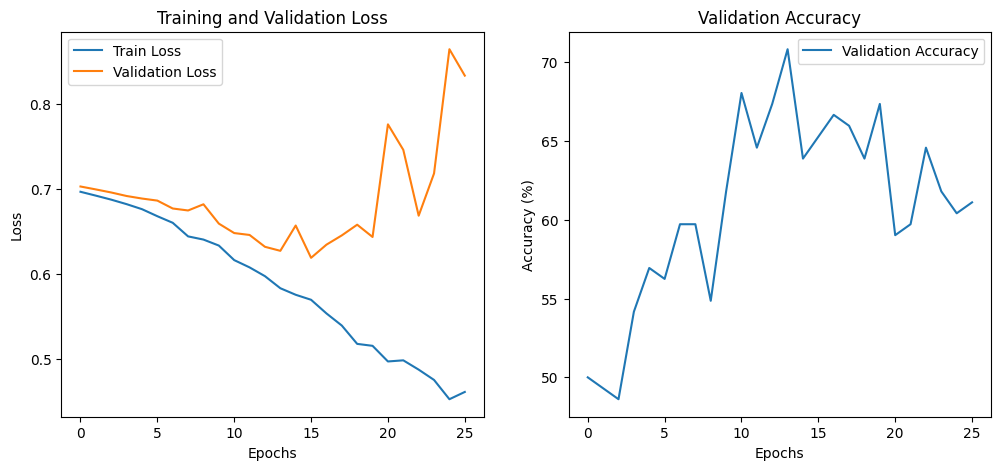

Test Loss: 0.4400, Test Accuracy: 79.86%
Test Subject 3: Test Acc = 79.86%, Test Loss = 0.4400
Training complete in 1m 57s

seed is 1255
Val Subject 5:
Epoch [1/100], Train Loss: 0.6948, Val Acc: 52.08%
Epoch [2/100], Train Loss: 0.6875, Val Acc: 51.39%
Epoch [3/100], Train Loss: 0.6957, Val Acc: 50.00%
Epoch [4/100], Train Loss: 0.6913, Val Acc: 51.39%
Epoch [5/100], Train Loss: 0.6911, Val Acc: 52.78%
Epoch [6/100], Train Loss: 0.6943, Val Acc: 52.08%
Epoch [7/100], Train Loss: 0.6994, Val Acc: 54.86%
Epoch [8/100], Train Loss: 0.7009, Val Acc: 56.94%
Epoch [9/100], Train Loss: 0.6943, Val Acc: 56.94%
Epoch [10/100], Train Loss: 0.7012, Val Acc: 59.03%
Epoch [11/100], Train Loss: 0.6690, Val Acc: 56.94%
Early stopping


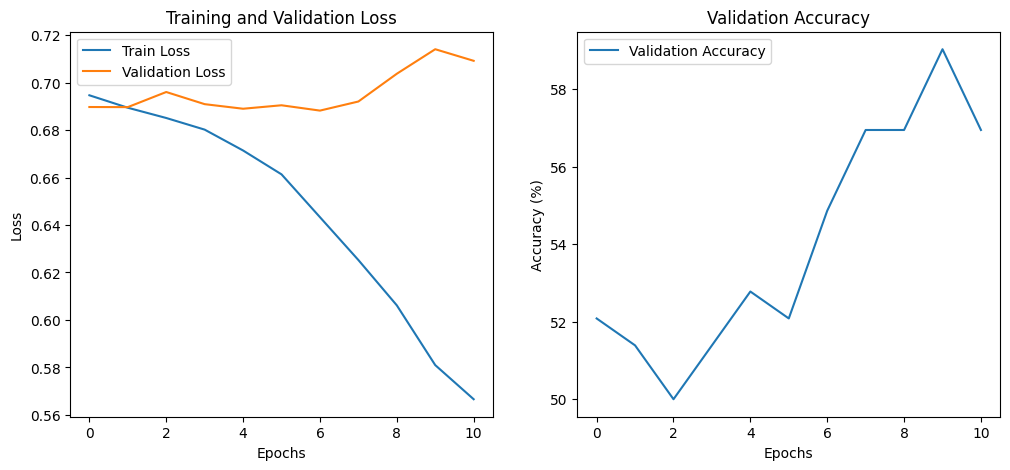

Test Loss: 0.5819, Test Accuracy: 63.89%
Test Subject 4: Test Acc = 63.89%, Test Loss = 0.5819
Training complete in 0m 50s

seed is 521
Val Subject 6:
Epoch [1/100], Train Loss: 0.6944, Val Acc: 50.69%
Epoch [2/100], Train Loss: 0.6994, Val Acc: 52.08%
Epoch [3/100], Train Loss: 0.7105, Val Acc: 57.64%
Epoch [4/100], Train Loss: 0.7219, Val Acc: 59.03%
Epoch [5/100], Train Loss: 0.7207, Val Acc: 58.33%
Epoch [6/100], Train Loss: 0.7209, Val Acc: 55.56%
Epoch [7/100], Train Loss: 0.7157, Val Acc: 63.19%
Epoch [8/100], Train Loss: 0.6980, Val Acc: 63.19%
Epoch [9/100], Train Loss: 0.6776, Val Acc: 62.50%
Epoch [10/100], Train Loss: 0.6668, Val Acc: 63.89%
Epoch [11/100], Train Loss: 0.6426, Val Acc: 64.58%
Epoch [12/100], Train Loss: 0.6039, Val Acc: 70.83%
Epoch [13/100], Train Loss: 0.6065, Val Acc: 69.44%
Epoch [14/100], Train Loss: 0.6030, Val Acc: 70.14%
Epoch [15/100], Train Loss: 0.5554, Val Acc: 70.14%
Epoch [16/100], Train Loss: 0.5882, Val Acc: 68.75%
Epoch [17/100], Train Loss

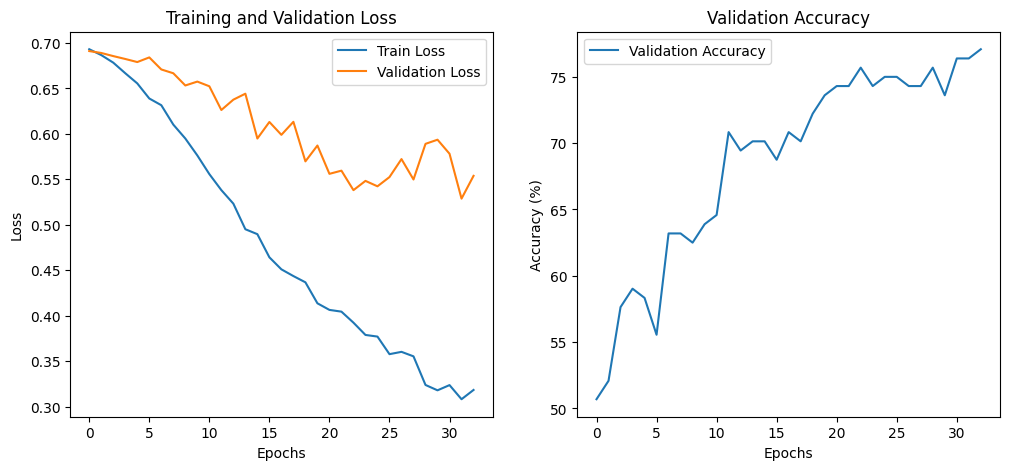

Test Loss: 0.8938, Test Accuracy: 65.28%
Test Subject 5: Test Acc = 65.28%, Test Loss = 0.8938
Training complete in 2m 29s

seed is 408
Val Subject 7:
Epoch [1/100], Train Loss: 0.6909, Val Acc: 51.39%
Epoch [2/100], Train Loss: 0.6917, Val Acc: 52.78%
Epoch [3/100], Train Loss: 0.6854, Val Acc: 61.81%
Epoch [4/100], Train Loss: 0.6886, Val Acc: 51.39%
Epoch [5/100], Train Loss: 0.6815, Val Acc: 51.39%
Epoch [6/100], Train Loss: 0.6808, Val Acc: 60.42%
Epoch [7/100], Train Loss: 0.6757, Val Acc: 56.94%
Epoch [8/100], Train Loss: 0.6754, Val Acc: 64.58%
Epoch [9/100], Train Loss: 0.6932, Val Acc: 52.08%
Epoch [10/100], Train Loss: 0.6993, Val Acc: 53.47%
Epoch [11/100], Train Loss: 0.7073, Val Acc: 55.56%
Epoch [12/100], Train Loss: 0.7360, Val Acc: 55.56%
Epoch [13/100], Train Loss: 0.7402, Val Acc: 52.78%
Epoch [14/100], Train Loss: 0.7441, Val Acc: 57.64%
Epoch [15/100], Train Loss: 0.7373, Val Acc: 58.33%
Epoch [16/100], Train Loss: 0.7430, Val Acc: 56.25%
Early stopping


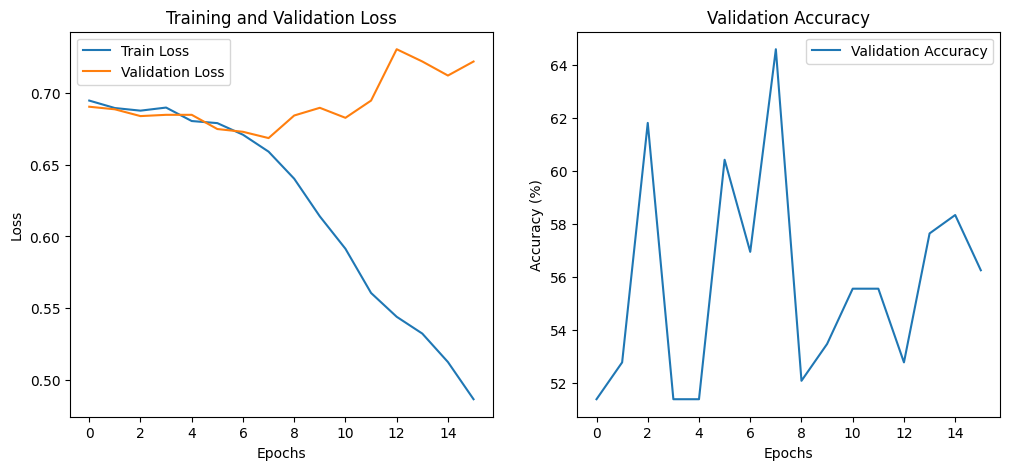

Test Loss: 0.5965, Test Accuracy: 70.14%
Test Subject 6: Test Acc = 70.14%, Test Loss = 0.5965
Training complete in 1m 12s

seed is 348
Val Subject 8:
Epoch [1/100], Train Loss: 0.6913, Val Acc: 47.92%
Epoch [2/100], Train Loss: 0.6915, Val Acc: 51.39%
Epoch [3/100], Train Loss: 0.6906, Val Acc: 50.69%
Epoch [4/100], Train Loss: 0.6904, Val Acc: 50.00%
Epoch [5/100], Train Loss: 0.6901, Val Acc: 50.69%
Epoch [6/100], Train Loss: 0.6900, Val Acc: 52.08%
Epoch [7/100], Train Loss: 0.6877, Val Acc: 50.69%
Epoch [8/100], Train Loss: 0.6910, Val Acc: 50.00%
Epoch [9/100], Train Loss: 0.6687, Val Acc: 70.14%
Epoch [10/100], Train Loss: 0.6761, Val Acc: 50.69%
Epoch [11/100], Train Loss: 0.6464, Val Acc: 63.19%
Epoch [12/100], Train Loss: 0.6368, Val Acc: 57.64%
Epoch [13/100], Train Loss: 0.6126, Val Acc: 68.75%
Epoch [14/100], Train Loss: 0.5755, Val Acc: 81.25%
Epoch [15/100], Train Loss: 0.5559, Val Acc: 80.56%
Epoch [16/100], Train Loss: 0.5165, Val Acc: 87.50%
Epoch [17/100], Train Loss

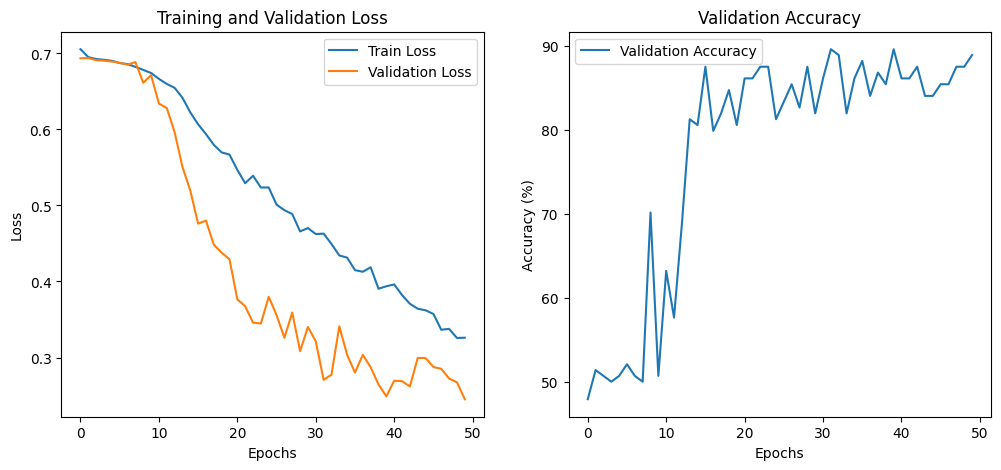

Test Loss: 0.9201, Test Accuracy: 59.72%
Test Subject 7: Test Acc = 59.72%, Test Loss = 0.9201
Training complete in 3m 45s

seed is 1973
Val Subject 9:
Epoch [1/100], Train Loss: 0.6802, Val Acc: 52.08%
Epoch [2/100], Train Loss: 0.6801, Val Acc: 48.61%
Epoch [3/100], Train Loss: 0.6758, Val Acc: 52.08%
Epoch [4/100], Train Loss: 0.6685, Val Acc: 54.86%
Epoch [5/100], Train Loss: 0.6623, Val Acc: 54.86%
Epoch [6/100], Train Loss: 0.6548, Val Acc: 50.69%
Epoch [7/100], Train Loss: 0.6448, Val Acc: 54.17%
Epoch [8/100], Train Loss: 0.7053, Val Acc: 50.00%
Epoch [9/100], Train Loss: 0.6422, Val Acc: 51.39%
Epoch [10/100], Train Loss: 0.6272, Val Acc: 55.56%
Epoch [11/100], Train Loss: 0.6635, Val Acc: 50.69%
Epoch [12/100], Train Loss: 0.6585, Val Acc: 52.78%
Epoch [13/100], Train Loss: 0.6382, Val Acc: 54.17%
Epoch [14/100], Train Loss: 0.6338, Val Acc: 54.17%
Epoch [15/100], Train Loss: 0.6578, Val Acc: 52.08%
Epoch [16/100], Train Loss: 0.6358, Val Acc: 55.56%
Epoch [17/100], Train Los

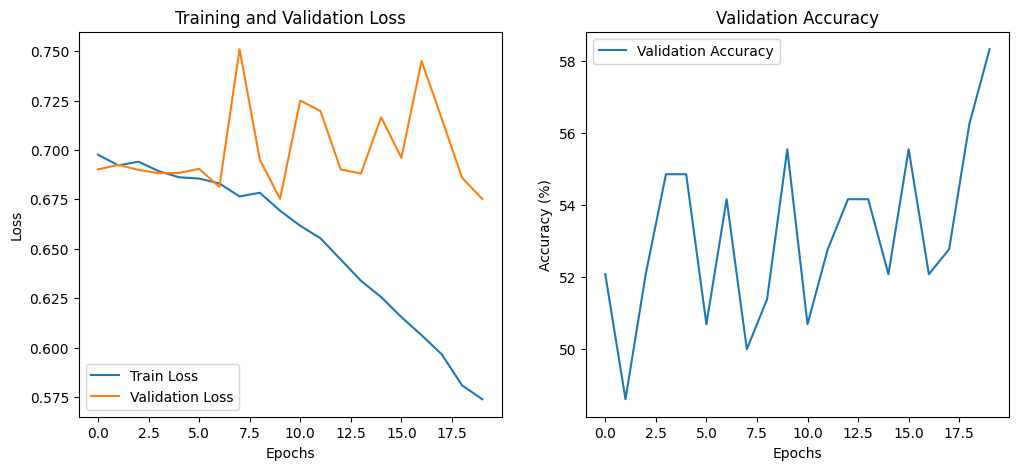

Test Loss: 0.5481, Test Accuracy: 67.36%
Test Subject 8: Test Acc = 67.36%, Test Loss = 0.5481
Training complete in 1m 30s

seed is 684
Val Subject 1:
Epoch [1/100], Train Loss: 0.6848, Val Acc: 47.92%
Epoch [2/100], Train Loss: 0.6765, Val Acc: 51.39%
Epoch [3/100], Train Loss: 0.6700, Val Acc: 52.78%
Epoch [4/100], Train Loss: 0.6603, Val Acc: 54.17%
Epoch [5/100], Train Loss: 0.6891, Val Acc: 58.33%
Epoch [6/100], Train Loss: 0.6702, Val Acc: 61.11%
Epoch [7/100], Train Loss: 0.6236, Val Acc: 59.03%
Epoch [8/100], Train Loss: 0.6841, Val Acc: 57.64%
Epoch [9/100], Train Loss: 0.6510, Val Acc: 62.50%
Epoch [10/100], Train Loss: 0.6376, Val Acc: 63.19%
Epoch [11/100], Train Loss: 0.5818, Val Acc: 65.97%
Epoch [12/100], Train Loss: 0.5454, Val Acc: 67.36%
Epoch [13/100], Train Loss: 0.5531, Val Acc: 67.36%
Epoch [14/100], Train Loss: 0.5604, Val Acc: 68.75%
Epoch [15/100], Train Loss: 0.5391, Val Acc: 65.97%
Epoch [16/100], Train Loss: 0.6024, Val Acc: 69.44%
Epoch [17/100], Train Loss

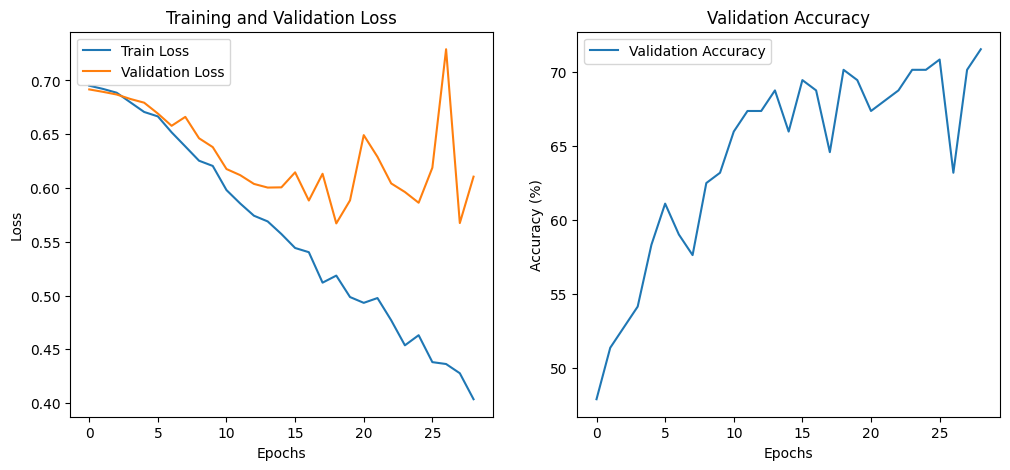

Test Loss: 0.6555, Test Accuracy: 62.50%
Test Subject 9: Test Acc = 62.50%, Test Loss = 0.6555
Training complete in 2m 11s

Average Test Accuracy: 64.04%
Average Test Loss: 0.7326
   Test Subject  Val Subject   Test Acc  Seed
0             1            2  56.944444   362
1             2            3  50.694444  1585
2             3            4  79.861111    52
3             4            5  63.888889  1255
4             5            6  65.277778   521
5             6            7  70.138889   408
6             7            8  59.722222   348
7             8            9  67.361111  1973
8             9            1  62.500000   684


In [20]:
# Assuming you have n subjects in your dataset
n_subjects = 9

# Results storage
all_test_accuracies = []
all_test_losses = []

# Initialize an empty DataFrame
results_df = pd.DataFrame(columns=['Test Subject', 'Val Subject', 'Test Acc', 'Seed'])

for test_sub in range(n_subjects):
    start_time = time.time()
    
    seed_n = np.random.randint(2021)
    print('seed is ' + str(seed_n))
    random.seed(seed_n)
    np.random.seed(seed_n)
    torch.manual_seed(seed_n)
    torch.cuda.manual_seed(seed_n)
    torch.cuda.manual_seed_all(seed_n)
    
    # Selecting the validation subject (can be the same or different from the test subject)
    val_sub = (test_sub + 1) % n_subjects
    print(f"Val Subject {val_sub + 1}:")

    # Initialize model and get source data for this iteration
    model, parameters, loss_functions = initialize_model(test_sub, val_sub, n_subjects)
    X_train, y_train, X_val, y_val, X_test, y_test = get_source_data(test_sub, val_sub, n_subjects)
    train_loader, val_loader = prepare_dataloaders(X_train, y_train, X_val, y_val, parameters['batch_size'])
    test_loader = prepare_dataloaders(X_test, y_test, X_test, y_test, parameters['batch_size'])[1]  # Only need test loader

    optimizer = torch.optim.Adam(model.parameters(), lr=parameters['lr'], betas=(parameters['b1'], parameters['b2']))

    # Train the model
    early_stopping = EarlyStopping(patience=10, min_delta=0.01)
    trained_model, train_losses, val_losses, val_accuracies = train_model(model, optimizer, loss_functions, train_loader, val_loader, parameters, X_train, y_train, early_stopping)
    
    # Number of epochs trained is either the total number of epochs or until early stopping
    epochs_trained = parameters['n_epochs'] if not early_stopping.early_stop else early_stopping.counter
    
    # Plotting
    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()
    
    # Test the model
    test_accuracy, test_loss = test_model(trained_model, loss_functions, test_loader)

    # Store results
    all_test_accuracies.append(test_accuracy)
    all_test_losses.append(test_loss)

    print(f"Test Subject {test_sub + 1}: Test Acc = {test_accuracy:.2f}%, Test Loss = {test_loss:.4f}")
    
    time_elapsed = time.time() - start_time
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('\n======================================')
    
    # Add the results to the DataFrame
    results_df.loc[len(results_df)] = {
        'Test Subject': test_sub + 1,
        'Val Subject' : val_sub + 1,
        'Test Acc'    : test_accuracy,
        'Seed'        : seed_n
}

# Calculate average performance across all LOSO rounds
average_accuracy = np.mean(all_test_accuracies)
average_loss = np.mean(all_test_losses)

print(f"Average Test Accuracy: {average_accuracy:.2f}%")
print(f"Average Test Loss: {average_loss:.4f}")

# Display the results DataFrame
print(results_df)

## Utility Functions

In [ ]:
def save_model(model, path):
    """
    Save the trained model to a file.
    :param model: The trained model.
    :param path: File path to save the model.
    """
    torch.save(model.state_dict(), path)

def load_model(path):
    """
    Load a model from a file.
    :param path: File path to the model.
    :return: Loaded model.
    """
    # Instantiate the model
    model = model_class(*args, **kwargs)
    
    # Load the model state dict
    model.load_state_dict(torch.load(path))
    
    return model


In [ ]:
save_model(trained_model, 'results_2024_conf/model_cct.pth')

In [ ]:
my_loaded_model = load_model('results_2024_conf/model_cct.pth', ['left_hand', 'right_hand'])